<a href="https://colab.research.google.com/github/AzizKazi/weatherwise-Aziz-kazi/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
!pip install pyinputplus matplotlib requests


Import required packages

In [98]:
import os
import requests
import matplotlib.pyplot as plt
import pyinputplus as pyip

## 🌤️ Weather Data Functions to fetch weather details


In [99]:
def fetch_weather(city, days=3):
    """
    Fetches weather forecast json data for the given city and days from wttr.in API.
    """
    api_url = f"https://wttr.in/{city}?format=j1"
    try:
        response = requests.get(api_url)
        response.raise_for_status()
        data = response.json()
        data['weather'] = data['weather'][:days]
        return data
    except Exception as e:
        print(f"Failed to retrieve weather data: {e}")
        return None

## 📊 Visualisation Functions

function to display maximum and minimum temperature

In [100]:
def visualize_temperature(data, show_or_return='display'):
    """
    Shows a temperature plot with a different style: bar + dotted line plot.
    """
    date_labels = []
    high_vals = []
    low_vals = []

    for day in data['weather']:
        date_labels.append(day['date'])
        high_vals.append(float(day['maxtempC']))
        low_vals.append(float(day['mintempC']))

    plt.ion()
    fig, ax = plt.subplots()
    ax.bar(date_labels, high_vals, color='purple', alpha=0.7, label='Max Temp (°C)')
    ax.plot(date_labels, low_vals, color='brown', marker='d', linestyle=':', label='Min Temp (°C)')
    ax.set_title("Daily Temperature Overview")
    ax.set_xlabel("Date")
    ax.set_ylabel("Temperature (°C)")
    ax.legend()
    plt.grid(True)

    plt.show()
    plt.pause(0.1)
    plt.close(fig)
    plt.ioff()

In [101]:
def visualize_rainfall(data, show_or_return='display'):
    """
    Visualizes daily rainfall using horizontal bars with a distinct color scheme.
    """
    dates = [d['date'] for d in data['weather']]
    rain_vals = [sum(float(h['precipMM']) for h in d['hourly']) for d in data['weather']]
    max_rain = max(rain_vals) if rain_vals else 1
    alpha_values = [v / max_rain for v in rain_vals]

    fig, ax = plt.subplots()
    ax.barh(dates, rain_vals, color=[(1, 0.6, 0, a) for a in alpha_values])
    ax.set_title("Daily Rainfall Heatmap")
    ax.set_xlabel("Rain (mm)")
    ax.set_ylabel("Date")
    plt.grid(True)

    if show_or_return == 'figure':
        return fig
    else:
        plt.show()
        plt.pause(0.1)
        plt.close(fig)
        plt.ioff()


In [102]:
def visualize_wind(data, show_or_return='display'):
    """
    Displays wind speed via line plot with scatter points of midday winds.
    """
    days = []
    peak_wind = []
    noon_wind = []

    for day in data['weather']:
        days.append(day['date'])
        peak_wind.append(max(float(hour['windspeedKmph']) for hour in day['hourly']))
        # noon wind speed roughly middle of day hours (index 6 of 12 hours)
        noon_wind.append(float(day['hourly'][6]['windspeedKmph']))

    fig, ax = plt.subplots()
    ax.plot(days, peak_wind, color='navy', marker='p', linestyle='-', label='Peak Wind (km/h)')
    ax.scatter(days, noon_wind, color='red', label='Noon Wind Speed', s=60)
    ax.set_title("Wind Speed Analysis")
    ax.set_xlabel("Date")
    ax.set_ylabel("Speed (km/h)")
    ax.legend()
    plt.grid(True)

    if show_or_return == 'figure':
        return fig
    else:
        plt.show()
        plt.pause(0.1)
        plt.close(fig)
        plt.ioff()

## 🤖 Natural Language Processing

In [103]:
def interpret_question(user_q):
    """
    Extract important keywords for weather questions.
    """
    user_q = user_q.lower()
    weather_features = ['temperature', 'rain', 'precipitation', 'humidity', 'wind']
    days_terms = ['today', 'tomorrow', 'day after tomorrow']
    city_name, key_feature, day_term = None, None, 'today'

    for f in weather_features:
        if f in user_q:
            key_feature = f
            break
    for t in days_terms:
        if t in user_q:
            day_term = t
            break

    tokens = user_q.split()
    if 'in' in tokens:
        pos = tokens.index('in')
        if pos + 1 < len(tokens):
            city_name = tokens[pos + 1]
    else:
        city_name = 'Sydney'

    return {'location': city_name, 'attribute': key_feature, 'time_period': day_term}


## 🧩 Main Application Logic

In [104]:
# Tie everything together here
def build_response(parsed_q, weather):
    """
    Create readable response text from a parsed question and weather data.
    """
    loc = parsed_q['location']
    attr = parsed_q['attribute']
    time_p = parsed_q['time_period']
    day_index = 0
    if time_p == 'tomorrow':
        day_index = 1
    elif time_p == 'day after tomorrow':
        day_index = 2

    try:
        single_day = weather['weather'][day_index]
        if attr in ['temperature', None]:
            max_t = single_day['maxtempC']
            min_t = single_day['mintempC']
            return f"In {loc.title()} on {single_day['date']}, temperatures range from {min_t}°C to {max_t}°C."
        elif attr in ['rain', 'precipitation']:
            rain_amount = sum(float(h['precipMM']) for h in single_day['hourly'])
            return f"In {loc.title()} on {single_day['date']}, expected rainfall is {rain_amount:.1f} mm."
        elif attr == 'humidity':
            humidity_lvl = single_day['hourly'][0]['humidity']
            return f"In {loc.title()} on {single_day['date']}, humidity will be about {humidity_lvl}%."
        elif attr == 'wind':
            wind_spd = single_day['hourly'][0]['windspeedKmph']
            return f"In {loc.title()} on {single_day['date']}, wind speed forecast is {wind_spd} km/h."
        else:
            return "Sorry, I couldn't understand that weather attribute."
    except Exception as err:
        return f"Sorry, weather data retrieval error: {err}"


## 🧭 User Interface

=== Weather Guide ===

Select an option:
1 - Get Weather Summary
2 - Ask Weather Question
3 - Show Temperature Chart
4 - Show Rainfall Chart
5 - Show Wind Data
6 - Exit
Choose (1-6): 1
Enter city name: perth
In Perth on 2025-10-17, temperatures range from 15°C to 25°C.

Select an option:
1 - Get Weather Summary
2 - Ask Weather Question
3 - Show Temperature Chart
4 - Show Rainfall Chart
5 - Show Wind Data
6 - Exit
Choose (1-6): 3
Enter city name: perth


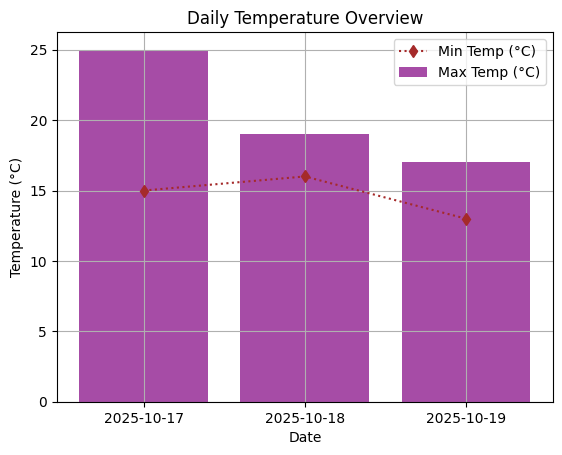


Select an option:
1 - Get Weather Summary
2 - Ask Weather Question
3 - Show Temperature Chart
4 - Show Rainfall Chart
5 - Show Wind Data
6 - Exit
Choose (1-6): 6
Goodbye! Stay weather-aware!


In [105]:
def weather_app_menu():
    """
    Interactive menu for friend’s version of the weather app.
    """
    print("=== Weather Guide ===")
    while True:
        print("\nSelect an option:")
        print("1 - Get Weather Summary")
        print("2 - Ask Weather Question")
        print("3 - Show Temperature Chart")
        print("4 - Show Rainfall Chart")
        print("5 - Show Wind Data")
        print("6 - Exit")

        option = pyip.inputChoice(['1','2','3','4','5','6'], prompt="Choose (1-6): ")

        if option == '6':
            print("Goodbye! Stay weather-aware!")
            break

        city_val = pyip.inputStr(prompt="Enter city name: ")
        weather_info = fetch_weather(city_val, days=3)

        if not weather_info:
            print("Data unavailable. Please try later.")
            continue

        if option == '1':
            print(build_response({'location': city_val, 'attribute': None, 'time_period': 'today'}, weather_info))
        elif option == '2':
            user_input = pyip.inputStr(prompt="Ask your weather question: ")
            parsed_input = interpret_question(user_input)
            parsed_input['location'] = city_val
            answer = build_response(parsed_input, weather_info)
            print(answer)
        elif option == '3':
            visualize_temperature(weather_info)
        elif option == '4':
            visualize_rainfall(weather_info)
        elif option == '5':
            visualize_wind(weather_info)

if __name__ == "__main__":
    weather_app_menu()

## 🧪 Testing and Examples

In [ ]:
class TestWeatherAdvisor(unittest.TestCase):
    @patch('requests.get')
    def test_get_weather_data_success(self, mock_get):

        mock_response = Mock()
        mock_response.status_code = 200
        mock_response.json.return_value = {
            'weather': [
                {'date': '2025-10-16', 'maxtempC': '25', 'mintempC': '15', 'hourly': [{'precipMM': '0'}]*8},
                {'date': '2025-10-17', 'maxtempC': '22', 'mintempC': '13', 'hourly': [{'precipMM': '1'}]*8},
                {'date': '2025-10-18', 'maxtempC': '20', 'mintempC': '12', 'hourly': [{'precipMM': '2'}]*8}
            ]
        }
        mock_get.return_value = mock_response

        result = fetch_weather('Perth', 3)
        self.assertIsNotNone(result)
        self.assertEqual(len(result['weather']), 3)
        self.assertEqual(result['weather'][0]['date'], '2025-10-16')

    @patch('requests.get')
    def test_get_weather_data_network_error(self, mock_get):
        mock_get.side_effect = Exception("Network error")
        result = fetch_weather('Perth', 3)
        self.assertIsNone(result)

if __name__ == "__main__":
    weather_app_menu()
    # To execute the tests, comment out the menu above and run:
    # unittest.main(argv=['first-arg-is-ignored'], exit=False)

## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.